## Table of contents:
* [Set env](#set_env)
* [General information on Reactome biopax file](#general_reactome)
    * [Query 1: Number of elements for each biopax types](#query1)
* [Complexes](#complexes)
    * [Complexes in BioPAX specifications](#complexes_in_biopax)
    * [Complexes in Reactome](#complex_reactome)
        * [Summary](#summary)
        * [Query 2: How many black-box complexes?](#query2) 
        * [Query 3: How many complexes have at least one component? ](#query3)
        * [Query 4: How many complexes have at least one component that is a complex? ](#query4)
        * [Query 5: How many complexes have at least one component, none of which is a complex? ](#query5)
        * [Query 6: How many complexes have at least one component that is a blackbox complex ](#query6)
        * [Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? ](#query7)
        * [Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? ](#query8)
        * [Query 9: How many complexes, that are not black boxes, are a component of at least another complex? ](#query9)
        * [Query 10: Distribution of the number of direct components by complex ](#query10)  
        * [Query 11: Distribution of the number of complexes a complex is a component of](#query11)
        * [Query 12:  How many interactions directly involve an invalid complex? ?](#query12)
        * [Query 13: How many different components are involved in the invalid complexes?](#query13)
        * [Query 14: How many interactions directly involve a component of an invalid complex?](#query14)
        * [Query 15: How many interactions involve a complex having a direct component that is a component of an invalid complex?](#query15)
        * [Query 16: How many interactions directly and indirectly involve these components?](#query16)
    * [Identify the redundant complexes](#identify_redundant)
        * [Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular localisation?](#query17)
        * [How many cliques?](#cliques)
    * [Fix the invalid complexes](#fix_complexes)  
        

### Environment <a class="anchor" id="set_env"></a>

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

import time
import jwt
import pathlib

import uri_utils
import complexComponents

In [2]:
reactomeVersion = 81
species = 49633
# species = 

endpointURL = "http://localhost:3030/REACTOME_SSCROFA/query"
rdfFormat = "turtle"

workspace = "."
path_results = workspace+'/results-'+str(reactomeVersion)+'-'+str(species)
if not os.path.exists(path_results) :
  os.makedirs(path_results)

prefixesDict = uri_utils.readPrefixesFromFile("defaultPrefixes-release" + 
                                              str(reactomeVersion) + ".json")


In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>

PREFIX up:<http://purl.uniprot.org/core/>
PREFIX udb: <http://purl.uniprot.org/database/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX reactome: <http://www.reactome.org/biopax/""" + str(reactomeVersion)+"""/"""+str(species)+"""#>
"""

### General information on the dataset (Reactome Biopax Homo Sapiens v79) <a class="anchor" id="general_reactome"></a>

Query 1: Number of elements for each biopax types <a class="anchor" id="query1"></a>

In [4]:
## Reactome - initial file
## Version xml:base="http://www.reactome.org/biopax/79/48887#"> (2022-02-03)

## Number of elements for each biopax types
query="""
# Number of elements for each biopax types in reactome
SELECT ?type (COUNT(DISTINCT(?element)) AS ?nb_elements)
WHERE {
  ?element a ?type.
  FILTER(STRSTARTS(STR(?type),str(bp3:)) )
}
GROUP BY ?type
ORDER BY DESC (?nb_elements)
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,type,nb_elements
0,http://www.biopax.org/release/biopax-level3.owl#UnificationXref,94540
1,http://www.biopax.org/release/biopax-level3.owl#SequenceSite,33103
2,http://www.biopax.org/release/biopax-level3.owl#Stoichiometry,22918
3,http://www.biopax.org/release/biopax-level3.owl#PublicationXref,22333
4,http://www.biopax.org/release/biopax-level3.owl#Protein,17805
5,http://www.biopax.org/release/biopax-level3.owl#FragmentFeature,15464
6,http://www.biopax.org/release/biopax-level3.owl#SequenceInterval,15464
7,http://www.biopax.org/release/biopax-level3.owl#Evidence,9153
8,http://www.biopax.org/release/biopax-level3.owl#PathwayStep,9126
9,http://www.biopax.org/release/biopax-level3.owl#Complex,9022


### Complexes <a class="anchor" id="complexes"></a>

#### Complexes in BioPAX specifications <a class="anchor" id="complexes_in_biopax"></a>

- **Complex** (BioPAX-level3 page 48)
    - physical product of an interaction
    - **complexes should not be defined recursively** (a complex should not be a component of another complex)
    - **exceptions are black box complexes** i.e. complexes in which the component property is empty
    - the `bp3:component` property
        - has domain: `bp3:Complex`
        - has range: `bp3:PhysicalEntity`, which subclasses are:
            - `bp3:Dna`
            - `bp3:Rna`
            - `bp3:Protein`
            - `bp3:Complex` warning: black box complexes only!
            - `bp3:SmallMolecule`
- **Black box complex**
- **Redundant complexes** are complexes having different identifiers, possibly from different databases but having the same chemical and physical properties
    - redundant complexes form equivalence classes

#### Complexes in Reactome <a class="anchor" id="complex_reactome"></a>
![](./2022_03_09_Complex_Biopax.png)

Query 2: How many black-box complexes? <a class="anchor" id="query2"></a>

In [5]:
## OD
query="""
# Blackbox complexes

SELECT (COUNT(DISTINCT ?complexBB) AS ?nbComplexesBB)
WHERE {
  ?complexBB rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexBB bp3:component ?complexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexesBB
0,488


Query 3: How many complexes have at least one component? <a class="anchor" id="query3"></a>

In [6]:
## OD
query="""
# Complexes that have at least one component
# i.e. complexes that are not blackbox complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,8534


Query 4: How many complexes have at least one component that is a complex? <a class="anchor" id="query4"></a>

In [7]:
## OD
query="""
# Complexes that have at least one component that is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3872


Query 5: How many complexes have at least one component, none of which is a complex? <a class="anchor" id="query5"></a>

In [8]:
## OD
query="""
# Complexes that have at least one component, none of which is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,4662


Query 6: How many complexes have at least one component that is a blackbox complex  <a class="anchor" id="query6"></a>

In [9]:
## OD
query="""
# Complexes that have at least one component that is a blackbox complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexComponent bp3:component ?someComplexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,381


Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? <a class="anchor" id="query7"></a>

In [10]:
## OD
query="""
# Complexes that have at least one component that is a complex, 
# and all its components that are complexes are actually black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
    ?someComplexComponent bp3:component ?someComplexComponentComponent .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,234


Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? <a class="anchor" id="query8"></a>

Number of invalid complexes

In [11]:
## OD
query="""
# All invalid complexes
# Complexes that have at least one component that is a complex, but not a black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  ?complexComponent bp3:component ?someComplexComponentComponent .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3638


Query 9: How many complexes, that are not black-boxes, are a component of at least another complex? <a class="anchor" id="query9"></a>

In [12]:
## OD
query="""
# Complexes that are not black boxes but are a component of at least another complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  
  ?superComplex bp3:component ?complex .
  ?superComplex rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3015


Query 10: Distribution of the number of direct components by complex <a class="anchor" id="query10"></a>

In [13]:
## OD
query="""
# Distribution of the number of direct components by complex

SELECT ?complex (COUNT(DISTINCT ?complexComponent) AS ?nbComponents)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?complex bp3:component ?complexComponent . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?complex bp3:component ?complexComponent . 
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbComponents"] = pandas.to_numeric(df["nbComponents"])
#df.to_csv("./direct_components.csv")
df["nbComponents"].describe()

count    9022.000000
mean        2.311461
std         2.923797
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        65.000000
Name: nbComponents, dtype: float64

Text(0.5, 0.98, 'Distribution of the number of direct components by complex')

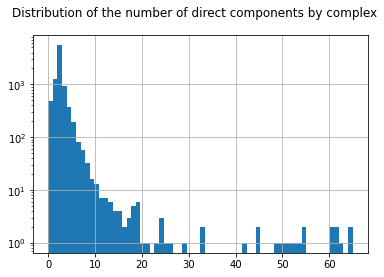

In [14]:
df['nbComponents'].hist(bins=df['nbComponents'].max()+1, log=True)
plt.suptitle("Distribution of the number of direct components by complex")

Query 11: Distribution of the number of complexes a complex is a component of<a class="anchor" id="query11"></a>

Text(0.5, 0.98, 'Distribution of the number of complexes a complex is a component of')

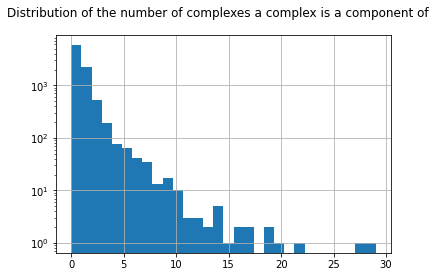

In [15]:
## OD
query="""
# Distribution of the number of complexes a complex is a component of

SELECT ?complex (COUNT(DISTINCT ?whole) AS ?nbWholes)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?whole bp3:component ?complex . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?whole bp3:component ?complex .
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbWholes"] = pandas.to_numeric(df["nbWholes"])
df["nbWholes"].describe()
df["nbWholes"].hist(bins=df['nbWholes'].max()+1, log=True)
plt.suptitle("Distribution of the number of complexes a complex is a component of")

Query 12: How many interactions **directly** involve invalid complexes? <a class="anchor" id="query12"></a>

In [16]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?interaction) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?complex .
  
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,12110


Query 13: How many different components (proteins, small molecules et physical entites) are involved in the invalid complexes? <a class="anchor" id="query13"></a>

In [17]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?leafComponent) AS ?nbInvalidComplexesComponents)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?someComplexComponentComponent .
  
  ?invalidComplex bp3:component+ ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInvalidComplexesComponents
0,5374


The 5,734 invalid complexes are (in)directly composed of 7,119 distinct entities that are not complexes, interactions, DNA or RNA. Nb: this excludes black-box complexes.

Query 14: How many interactions **directly** involve these components? <a class="anchor" id="query14"></a>

In [18]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#All interactions that have a participant that is a component of an invalid complex 

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .} 
  
  ?interact ?hasParticipant ?leafComponent .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,4394


Query 15: How many interactions involve a complex having a **direct** component that is a component of an invalid complex?  <a class="anchor" id="query15"></a>

Interactions involving a complex composed directly of a component of an invalid complex

In [19]:
query="""
# All interactions that have a participant that is a complex having a direct component that is a component of an invalid complex (excludes black-box complexes)

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  ?interactParticipant bp3:component? ?leafComponent . # 0 or 1 path
  ?interact ?hasParticipant ?interactParticipant .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,6641


Query 16: How many interactions **directly** and **indirectly** involve these components? <a class="anchor" id="query16"></a>

Interactions involving a complex (valid or invalid) composed indirectly of a component of an invalid complex or the component itself

In [20]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#Interactions involving a complex composed indirectly of a component of an invalid complex

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  
  ?interactParticipant bp3:component* ?leafComponent . # 0 or more paths
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .  
  ?interact ?hasParticipant ?interactParticipant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,7102


### Identify the redundant complexes <a class="anchor" id="identify_redundant"></a>

Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular location? <a class="anchor" id="query17"></a>

In [21]:
## OD CJ
query = """
# Retrieve redundant complexes i.e. pairs of complexes having different identifiers but the same components with the same stoichiometric coefficients
SELECT DISTINCT ?complex1  ?complex2 ?loc1# ?id1 ?id2 #?comp ?stoichioValue1 ?stoichioValue2

WHERE {
  #VALUES ?complex { reactome:Complex3 reactome:Complex7 reactome:Complex4 reactome:Complex5 reactome:Complex6 reactome:Complex8 reactome:Complex101 reactome:Complex102 }
  #VALUES ?complex { reactome:Complex102 }
  
  ?complex1 rdf:type bp3:Complex .
  # ?complex1 and ?complex2 have at least 1 common component (to avoid matching all the pairs of blackbox complexes that do not have any components)
  ?complex1 bp3:component ?commonComp .
  ?complex2 bp3:component ?commonComp .
  ?complex2 rdf:type bp3:Complex .
  ?complex1 bp3:cellularLocation ?loc1 .
  ?complex2 bp3:cellularLocation ?loc1 .
  FILTER (str(?complex1) < str(?complex2))
  # ?complex1 and ?complex2 do not have any common component that has different stoichiometric coefficients between the two complexes
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp .
    ?complex2 bp3:component ?comp .
    #?complex1 bp3:cellularLocation ?loc1 .
    ?complex1 bp3:componentStoichiometry ?stoichio1 .
    ?stoichio1 bp3:physicalEntity ?comp .
    ?stoichio1 bp3:stoichiometricCoefficient ?stoichioValue1 .

    ?complex2 bp3:componentStoichiometry ?stoichio2 .
    ?stoichio2 bp3:physicalEntity ?comp .
    #?complex2 bp3:cellularLocation ?loc2 .
    ?stoichio2 bp3:stoichiometricCoefficient ?stoichioValue2 .
    FILTER (?stoichioValue1 != ?stoichioValue2)
    #FILTER (?loc1 != ?loc2)
  }


  # all the direct components of ?complex1 are also components of ?complex2
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp1 .
    FILTER NOT EXISTS {
      ?complex2 bp3:component ?comp1 .
    }
  }
  # all the direct components of ?complex2 are also components of ?complex1
  FILTER NOT EXISTS {
    ?complex2 bp3:component ?comp2 .
    FILTER NOT EXISTS {
      ?complex1 bp3:component ?comp2 .
    }
  }
 OPTIONAL{ ?complex1 bp3:xref ?xref1 .
    ?xref1 bp3:db "ComplexPortal" .
    ?xref1 bp3:id ?id1 . }
  
OPTIONAL{ ?complex2 bp3:xref ?xref2 .
    ?xref2 bp3:db "ComplexPortal" .
    ?xref2 bp3:id ?id2 . }
}
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,complex1,complex2,loc1


How many cliques? <a class="anchor" id="cliques"></a>

In [22]:
cliques = {df["complex1"][0] : [df["complex2"][0]]}
for row in df.itertuples(index=False):
    if row[0] in cliques :
        cliques[row[0]].append(row[1])
    elif row[1] in cliques :
        cliques[row[1]].append(row[0])
    else :
        found = False
        for i in cliques :
            if row[0] in cliques[i]:
                cliques[i].append(row[1])
                found = True
                break
            elif row[1] in cliques[i]:
                cliques[i].append(row[0])
                found = True
                break
        if not found :
            cliques[row[0]] = list()
            cliques[row[0]].append(row[1])
       
len(cliques) 

IndexError: index 0 is out of bounds for axis 0 with size 0

* * *
### Fix the invalid complexes <a class="anchor" id="fix_complexes"></a>

- step 0: retrieve Reactome
       wget https://reactome.org/download/current/biopax.zip
       unzip biopax.zip Homo_sapiens.owl
       echo "Reactome version: $(expr "$(grep xml:base Homo_sapiens.owl)" : '.*http:\/\/www.reactome.org\/biopax\/\([[:digit:]]*\).*')"

- step 1: setup SPARQL endpoint with reactome
       # broken with fuseki-4.4.0: 
       # temporary fix
       ${FUSEKI_HOME}/fuseki-server --mem --update /reactome
       # then manually load Homo_sapiens.owl

- step 2: export the valid complexes

- step 3: export the fixed invalid complexes

- step 4: export reactome without complexes

- step 5: merge files 

![]("./Figure_drawio/2022_03_17_Stoichio.pdf")

Function 1: fix invalid complexes <a class="anchor" id="function1"></a>

In [23]:
def fixInvalidComplexes():
    ##### FIX INVALID COMPLEXES
    queryPath = 'queries/template-fixInvalidComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
#     sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    nbInvalidComplexes = len(results["results"]["bindings"])
    i = 0
    for result in results["results"]["bindings"]:
        print("{}\t{}\t{}".format(i, time.time()-startTime, result['invalidComplex']['value']))
        validGraph = rdflib.Graph()
        validGraph.bind("bp3","http://www.biopax.org/release/biopax-level3.owl#")
        complexComponents.getRepresentationBiopaxValid(endpointURL, result['invalidComplex']['value'], prefixesDict=prefixesDict, targetGraph=validGraph, rdfFormat="turtle", biopaxFilePath="")
        with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-" + result['invalidComplex']['value'].replace("http://www.reactome.org/biopax/" + str(reactomeVersion) + "/" + str(species) + "#", "") + "-valid.ttl", 'w',encoding="utf-8") as rdfFile:
            rdfFile.write(validGraph.serialize(format=rdfFormat))#.decode('UTF-8'))
        i += 1
    
     #${JENA_HOME}/bin/riot --time --output=Turtle result/reactome-v81-Complex*.ttl > reactome-v81-complexes-invalid-fixed.ttl

Function 2: export valid complexes <a class="anchor" id="function2"></a>

In [24]:
def exportValidComplexes():
    ##### EXPORT VALID PART OF REACTOME
    queryPath = 'queries/template-extractValidComplexes-construct.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(rdfFormat)
    results = sparql.query().convert()
    validGraph = rdflib.Graph()
    validGraph.parse(data=results, format=rdfFormat)

    with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-complexes-valid.ttl", 'w', encoding="utf-8") as rdfFile:
        rdfFile.write(validGraph.serialize(format=rdfFormat).encode().decode('UTF-8'))

Function 3: delete all complexes  <a class="anchor" id="function3"></a>

In [25]:
def deleteAllComplexes():
    queryPath = 'queries/deleteOriginalComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict))
    print("Calling: " + endpointURL.replace("query", "update"))
    sparql = SPARQLWrapper(endpointURL.replace("query", "update"))
    sparql.setQuery(sparqlQuery)
    sparql.method = 'POST'
    #sparql.setReturnFormat(JSON)
    sparql.query()

In [26]:
validGraph = rdflib.Graph()
sparql = SPARQLWrapper(endpointURL)

In [27]:
startTime = time.time()
fixInvalidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

0	0.3101980686187744	http://www.reactome.org/biopax/81/49633#Complex2
1	0.9985537528991699	http://www.reactome.org/biopax/81/49633#Complex9
2	1.5454144477844238	http://www.reactome.org/biopax/81/49633#Complex3
3	1.6746129989624023	http://www.reactome.org/biopax/81/49633#Complex5
4	1.9391789436340332	http://www.reactome.org/biopax/81/49633#Complex10
5	2.3859734535217285	http://www.reactome.org/biopax/81/49633#Complex12
6	2.814141273498535	http://www.reactome.org/biopax/81/49633#Complex13
7	3.030611753463745	http://www.reactome.org/biopax/81/49633#Complex17
8	3.5056676864624023	http://www.reactome.org/biopax/81/49633#Complex18
9	3.960296630859375	http://www.reactome.org/biopax/81/49633#Complex19
10	4.4394614696502686	http://www.reactome.org/biopax/81/49633#Complex21
11	4.5360119342803955	http://www.reactome.org/biopax/81/49633#Complex22
12	4.650894403457642	http://www.reactome.org/biopax/81/49633#Complex23
13	4.798040151596069	http://www.reactome.org/biopax/81/49633#Complex24
14	4.942444

114	20.557971477508545	http://www.reactome.org/biopax/81/49633#Complex259
115	20.832601070404053	http://www.reactome.org/biopax/81/49633#Complex260
116	20.932278871536255	http://www.reactome.org/biopax/81/49633#Complex263
117	21.020471334457397	http://www.reactome.org/biopax/81/49633#Complex265
118	21.117833375930786	http://www.reactome.org/biopax/81/49633#Complex267
119	21.296203136444092	http://www.reactome.org/biopax/81/49633#Complex270
120	21.578954696655273	http://www.reactome.org/biopax/81/49633#Complex271
121	21.905324697494507	http://www.reactome.org/biopax/81/49633#Complex272
122	22.072335243225098	http://www.reactome.org/biopax/81/49633#Complex275
123	22.245816707611084	http://www.reactome.org/biopax/81/49633#Complex278
124	22.33353543281555	http://www.reactome.org/biopax/81/49633#Complex281
125	22.417425632476807	http://www.reactome.org/biopax/81/49633#Complex283
126	22.505701065063477	http://www.reactome.org/biopax/81/49633#Complex285
127	22.597816705703735	http://www.react

227	38.710012912750244	http://www.reactome.org/biopax/81/49633#Complex568
228	38.75310778617859	http://www.reactome.org/biopax/81/49633#Complex571
229	38.85582637786865	http://www.reactome.org/biopax/81/49633#Complex574
230	39.030741691589355	http://www.reactome.org/biopax/81/49633#Complex572
231	39.06988739967346	http://www.reactome.org/biopax/81/49633#Complex575
232	39.19010281562805	http://www.reactome.org/biopax/81/49633#Complex577
233	39.38111329078674	http://www.reactome.org/biopax/81/49633#Complex580
234	39.61572265625	http://www.reactome.org/biopax/81/49633#Complex583
235	39.908419609069824	http://www.reactome.org/biopax/81/49633#Complex584
236	40.199830532073975	http://www.reactome.org/biopax/81/49633#Complex585
237	40.36356711387634	http://www.reactome.org/biopax/81/49633#Complex586
238	40.645798206329346	http://www.reactome.org/biopax/81/49633#Complex594
239	40.96796154975891	http://www.reactome.org/biopax/81/49633#Complex587
240	41.092742919921875	http://www.reactome.org/bi

339	56.401443004608154	http://www.reactome.org/biopax/81/49633#Complex777
340	56.58146834373474	http://www.reactome.org/biopax/81/49633#Complex779
341	57.00826549530029	http://www.reactome.org/biopax/81/49633#Complex781
342	57.32405185699463	http://www.reactome.org/biopax/81/49633#Complex786
343	57.73906087875366	http://www.reactome.org/biopax/81/49633#Complex787
344	58.12951874732971	http://www.reactome.org/biopax/81/49633#Complex788
345	58.37073254585266	http://www.reactome.org/biopax/81/49633#Complex789
346	58.56946301460266	http://www.reactome.org/biopax/81/49633#Complex790
347	58.81139779090881	http://www.reactome.org/biopax/81/49633#Complex792
348	58.87187600135803	http://www.reactome.org/biopax/81/49633#Complex793
349	58.998584032058716	http://www.reactome.org/biopax/81/49633#Complex795
350	59.14815354347229	http://www.reactome.org/biopax/81/49633#Complex796
351	59.20637798309326	http://www.reactome.org/biopax/81/49633#Complex798
352	59.26452898979187	http://www.reactome.org/bio

452	74.05873680114746	http://www.reactome.org/biopax/81/49633#Complex969
453	74.69798302650452	http://www.reactome.org/biopax/81/49633#Complex970
454	74.9253830909729	http://www.reactome.org/biopax/81/49633#Complex974
455	75.28478074073792	http://www.reactome.org/biopax/81/49633#Complex980
456	75.37578344345093	http://www.reactome.org/biopax/81/49633#Complex982
457	75.48574185371399	http://www.reactome.org/biopax/81/49633#Complex985
458	75.56525158882141	http://www.reactome.org/biopax/81/49633#Complex986
459	75.65145373344421	http://www.reactome.org/biopax/81/49633#Complex987
460	75.76804375648499	http://www.reactome.org/biopax/81/49633#Complex988
461	75.87963056564331	http://www.reactome.org/biopax/81/49633#Complex989
462	76.10292077064514	http://www.reactome.org/biopax/81/49633#Complex991
463	76.20495581626892	http://www.reactome.org/biopax/81/49633#Complex992
464	76.30401587486267	http://www.reactome.org/biopax/81/49633#Complex993
465	76.41875290870667	http://www.reactome.org/biopax

564	90.65527033805847	http://www.reactome.org/biopax/81/49633#Complex1181
565	90.7775673866272	http://www.reactome.org/biopax/81/49633#Complex1182
566	90.83252930641174	http://www.reactome.org/biopax/81/49633#Complex1185
567	91.07898449897766	http://www.reactome.org/biopax/81/49633#Complex1187
568	91.28308176994324	http://www.reactome.org/biopax/81/49633#Complex1188
569	91.51076006889343	http://www.reactome.org/biopax/81/49633#Complex1189
570	91.80188941955566	http://www.reactome.org/biopax/81/49633#Complex1192
571	92.01799130439758	http://www.reactome.org/biopax/81/49633#Complex1193
572	92.21709084510803	http://www.reactome.org/biopax/81/49633#Complex1197
573	92.49323058128357	http://www.reactome.org/biopax/81/49633#Complex1199
574	92.61785936355591	http://www.reactome.org/biopax/81/49633#Complex1202
575	92.84887862205505	http://www.reactome.org/biopax/81/49633#Complex1203
576	93.07811236381531	http://www.reactome.org/biopax/81/49633#Complex1200
577	93.17794013023376	http://www.reacto

676	105.42837619781494	http://www.reactome.org/biopax/81/49633#Complex1406
677	105.5906069278717	http://www.reactome.org/biopax/81/49633#Complex1409
678	105.75321912765503	http://www.reactome.org/biopax/81/49633#Complex1412
679	105.9666759967804	http://www.reactome.org/biopax/81/49633#Complex1413
680	106.18561887741089	http://www.reactome.org/biopax/81/49633#Complex1416
681	106.33427453041077	http://www.reactome.org/biopax/81/49633#Complex1418
682	106.49360060691833	http://www.reactome.org/biopax/81/49633#Complex1419
683	106.69549536705017	http://www.reactome.org/biopax/81/49633#Complex1420
684	106.83912491798401	http://www.reactome.org/biopax/81/49633#Complex1421
685	107.04218745231628	http://www.reactome.org/biopax/81/49633#Complex1422
686	107.15283966064453	http://www.reactome.org/biopax/81/49633#Complex1423
687	107.26005625724792	http://www.reactome.org/biopax/81/49633#Complex1424
688	107.3945541381836	http://www.reactome.org/biopax/81/49633#Complex1425
689	107.52664303779602	http:

787	117.93550324440002	http://www.reactome.org/biopax/81/49633#Complex1590
788	117.99528789520264	http://www.reactome.org/biopax/81/49633#Complex1593
789	118.0755021572113	http://www.reactome.org/biopax/81/49633#Complex1594
790	118.15406560897827	http://www.reactome.org/biopax/81/49633#Complex1596
791	118.25165033340454	http://www.reactome.org/biopax/81/49633#Complex1597
792	118.37496781349182	http://www.reactome.org/biopax/81/49633#Complex1598
793	118.7525143623352	http://www.reactome.org/biopax/81/49633#Complex1599
794	119.02868366241455	http://www.reactome.org/biopax/81/49633#Complex1600
795	119.18296456336975	http://www.reactome.org/biopax/81/49633#Complex1601
796	119.30421233177185	http://www.reactome.org/biopax/81/49633#Complex1603
797	119.73566746711731	http://www.reactome.org/biopax/81/49633#Complex1611
798	119.9674084186554	http://www.reactome.org/biopax/81/49633#Complex1604
799	120.23010039329529	http://www.reactome.org/biopax/81/49633#Complex1605
800	120.45380282402039	http:

899	188.69007182121277	http://www.reactome.org/biopax/81/49633#Complex2022
900	188.7690122127533	http://www.reactome.org/biopax/81/49633#Complex2023
901	188.87465143203735	http://www.reactome.org/biopax/81/49633#Complex2026
902	189.04335236549377	http://www.reactome.org/biopax/81/49633#Complex2027
903	189.17088985443115	http://www.reactome.org/biopax/81/49633#Complex2028
904	189.24288487434387	http://www.reactome.org/biopax/81/49633#Complex2029
905	189.463374376297	http://www.reactome.org/biopax/81/49633#Complex2030
906	189.65356850624084	http://www.reactome.org/biopax/81/49633#Complex2031
907	189.84599018096924	http://www.reactome.org/biopax/81/49633#Complex2032
908	189.97080183029175	http://www.reactome.org/biopax/81/49633#Complex2035
909	190.43768167495728	http://www.reactome.org/biopax/81/49633#Complex2039
910	190.66796851158142	http://www.reactome.org/biopax/81/49633#Complex2041
911	190.97395205497742	http://www.reactome.org/biopax/81/49633#Complex2042
912	191.27138710021973	http:

1009	217.88284730911255	http://www.reactome.org/biopax/81/49633#Complex2306
1010	218.1121060848236	http://www.reactome.org/biopax/81/49633#Complex2307
1011	218.38486218452454	http://www.reactome.org/biopax/81/49633#Complex2309
1012	218.43654894828796	http://www.reactome.org/biopax/81/49633#Complex2310
1013	218.71875047683716	http://www.reactome.org/biopax/81/49633#Complex2311
1014	219.05399298667908	http://www.reactome.org/biopax/81/49633#Complex2312
1015	219.25004720687866	http://www.reactome.org/biopax/81/49633#Complex2313
1016	219.53123331069946	http://www.reactome.org/biopax/81/49633#Complex2316
1017	219.65350103378296	http://www.reactome.org/biopax/81/49633#Complex2317
1018	219.775164604187	http://www.reactome.org/biopax/81/49633#Complex2320
1019	219.95251727104187	http://www.reactome.org/biopax/81/49633#Complex2322
1020	220.15771317481995	http://www.reactome.org/biopax/81/49633#Complex2328
1021	220.21065735816956	http://www.reactome.org/biopax/81/49633#Complex2329
1022	220.335086

1119	250.659508228302	http://www.reactome.org/biopax/81/49633#Complex2593
1120	250.73065972328186	http://www.reactome.org/biopax/81/49633#Complex2596
1121	250.81794095039368	http://www.reactome.org/biopax/81/49633#Complex2601
1122	250.89872860908508	http://www.reactome.org/biopax/81/49633#Complex2604
1123	251.0268132686615	http://www.reactome.org/biopax/81/49633#Complex2602
1124	251.07310843467712	http://www.reactome.org/biopax/81/49633#Complex2619
1125	251.17288327217102	http://www.reactome.org/biopax/81/49633#Complex2621
1126	251.34796380996704	http://www.reactome.org/biopax/81/49633#Complex2623
1127	251.49516415596008	http://www.reactome.org/biopax/81/49633#Complex2626
1128	251.67237210273743	http://www.reactome.org/biopax/81/49633#Complex2630
1129	251.75737237930298	http://www.reactome.org/biopax/81/49633#Complex2632
1130	251.86851477622986	http://www.reactome.org/biopax/81/49633#Complex2633
1131	252.0065507888794	http://www.reactome.org/biopax/81/49633#Complex2636
1132	252.0868859

1230	264.6187832355499	http://www.reactome.org/biopax/81/49633#Complex2827
1231	264.6805634498596	http://www.reactome.org/biopax/81/49633#Complex2830
1232	264.83537459373474	http://www.reactome.org/biopax/81/49633#Complex2832
1233	264.91569900512695	http://www.reactome.org/biopax/81/49633#Complex2836
1234	265.11039304733276	http://www.reactome.org/biopax/81/49633#Complex2838
1235	265.3807792663574	http://www.reactome.org/biopax/81/49633#Complex2841
1236	265.75596594810486	http://www.reactome.org/biopax/81/49633#Complex2839
1237	265.92786407470703	http://www.reactome.org/biopax/81/49633#Complex2842
1238	266.37455582618713	http://www.reactome.org/biopax/81/49633#Complex2843
1239	266.81810331344604	http://www.reactome.org/biopax/81/49633#Complex2844
1240	267.2570767402649	http://www.reactome.org/biopax/81/49633#Complex2845
1241	267.67397832870483	http://www.reactome.org/biopax/81/49633#Complex2846
1242	268.04238724708557	http://www.reactome.org/biopax/81/49633#Complex2847
1243	268.2897491

1339	286.1676161289215	http://www.reactome.org/biopax/81/49633#Complex3168
1340	286.32657504081726	http://www.reactome.org/biopax/81/49633#Complex3169
1341	286.43058729171753	http://www.reactome.org/biopax/81/49633#Complex3188
1342	287.4120714664459	http://www.reactome.org/biopax/81/49633#Complex3189
1343	287.9878616333008	http://www.reactome.org/biopax/81/49633#Complex3190
1344	288.432505607605	http://www.reactome.org/biopax/81/49633#Complex3191
1345	288.7429847717285	http://www.reactome.org/biopax/81/49633#Complex3192
1346	288.90120935440063	http://www.reactome.org/biopax/81/49633#Complex3199
1347	288.95633912086487	http://www.reactome.org/biopax/81/49633#Complex3193
1348	289.06179904937744	http://www.reactome.org/biopax/81/49633#Complex3195
1349	289.19307112693787	http://www.reactome.org/biopax/81/49633#Complex3209
1350	289.2984502315521	http://www.reactome.org/biopax/81/49633#Complex3210
1351	289.46181631088257	http://www.reactome.org/biopax/81/49633#Complex3211
1352	289.7119915485

1450	390.5553343296051	http://www.reactome.org/biopax/81/49633#Complex3432
1451	395.5633041858673	http://www.reactome.org/biopax/81/49633#Complex3433
1452	400.65746784210205	http://www.reactome.org/biopax/81/49633#Complex3435
1453	400.7838292121887	http://www.reactome.org/biopax/81/49633#Complex3436
1454	400.9103014469147	http://www.reactome.org/biopax/81/49633#Complex3439
1455	401.0599970817566	http://www.reactome.org/biopax/81/49633#Complex3442
1456	401.1905918121338	http://www.reactome.org/biopax/81/49633#Complex3440
1457	401.3143663406372	http://www.reactome.org/biopax/81/49633#Complex3443
1458	401.4208266735077	http://www.reactome.org/biopax/81/49633#Complex3445
1459	401.52874422073364	http://www.reactome.org/biopax/81/49633#Complex3448
1460	401.7006778717041	http://www.reactome.org/biopax/81/49633#Complex3451
1461	401.9092264175415	http://www.reactome.org/biopax/81/49633#Complex3454
1462	402.0627646446228	http://www.reactome.org/biopax/81/49633#Complex3455
1463	402.33077907562256

1560	539.2810673713684	http://www.reactome.org/biopax/81/49633#Complex3642
1561	539.7347180843353	http://www.reactome.org/biopax/81/49633#Complex3643
1562	540.0945608615875	http://www.reactome.org/biopax/81/49633#Complex3646
1563	540.1731398105621	http://www.reactome.org/biopax/81/49633#Complex3647
1564	540.2545702457428	http://www.reactome.org/biopax/81/49633#Complex3650
1565	540.3923819065094	http://www.reactome.org/biopax/81/49633#Complex3652
1566	540.4716818332672	http://www.reactome.org/biopax/81/49633#Complex3653
1567	540.5818727016449	http://www.reactome.org/biopax/81/49633#Complex3655
1568	540.7532422542572	http://www.reactome.org/biopax/81/49633#Complex3656
1569	540.8976273536682	http://www.reactome.org/biopax/81/49633#Complex3657
1570	541.0976145267487	http://www.reactome.org/biopax/81/49633#Complex3659
1571	541.3779196739197	http://www.reactome.org/biopax/81/49633#Complex3670
1572	541.7090203762054	http://www.reactome.org/biopax/81/49633#Complex3673
1573	541.9617550373077	ht

1670	674.8064994812012	http://www.reactome.org/biopax/81/49633#Complex3862
1671	675.1453120708466	http://www.reactome.org/biopax/81/49633#Complex3897
1672	675.2675187587738	http://www.reactome.org/biopax/81/49633#Complex3899
1673	675.3710565567017	http://www.reactome.org/biopax/81/49633#Complex3904
1674	675.447300195694	http://www.reactome.org/biopax/81/49633#Complex3906
1675	675.5647609233856	http://www.reactome.org/biopax/81/49633#Complex3915
1676	675.765969991684	http://www.reactome.org/biopax/81/49633#Complex3930
1677	675.8493344783783	http://www.reactome.org/biopax/81/49633#Complex3935
1678	678.289148569107	http://www.reactome.org/biopax/81/49633#Complex3936
1679	681.087984085083	http://www.reactome.org/biopax/81/49633#Complex3938
1680	681.7428450584412	http://www.reactome.org/biopax/81/49633#Complex3940
1681	681.937703371048	http://www.reactome.org/biopax/81/49633#Complex3957
1682	682.0683887004852	http://www.reactome.org/biopax/81/49633#Complex3959
1683	682.1847679615021	http://

1780	701.3551795482635	http://www.reactome.org/biopax/81/49633#Complex4265
1781	701.5054059028625	http://www.reactome.org/biopax/81/49633#Complex4266
1782	701.5921857357025	http://www.reactome.org/biopax/81/49633#Complex4267
1783	701.7071821689606	http://www.reactome.org/biopax/81/49633#Complex4269
1784	701.7616078853607	http://www.reactome.org/biopax/81/49633#Complex4271
1785	701.844500541687	http://www.reactome.org/biopax/81/49633#Complex4272
1786	701.9606189727783	http://www.reactome.org/biopax/81/49633#Complex4273
1787	702.0393450260162	http://www.reactome.org/biopax/81/49633#Complex4274
1788	702.0996947288513	http://www.reactome.org/biopax/81/49633#Complex4275
1789	702.2200956344604	http://www.reactome.org/biopax/81/49633#Complex4279
1790	702.2778189182281	http://www.reactome.org/biopax/81/49633#Complex4281
1791	702.3350336551666	http://www.reactome.org/biopax/81/49633#Complex4283
1792	702.3902473449707	http://www.reactome.org/biopax/81/49633#Complex4285
1793	702.4482786655426	htt

1891	717.0573997497559	http://www.reactome.org/biopax/81/49633#Complex4567
1892	717.1705327033997	http://www.reactome.org/biopax/81/49633#Complex4568
1893	717.278491973877	http://www.reactome.org/biopax/81/49633#Complex4570
1894	717.4248678684235	http://www.reactome.org/biopax/81/49633#Complex4571
1895	717.5572736263275	http://www.reactome.org/biopax/81/49633#Complex4573
1896	717.7300908565521	http://www.reactome.org/biopax/81/49633#Complex4574
1897	717.8292410373688	http://www.reactome.org/biopax/81/49633#Complex4577
1898	717.9527039527893	http://www.reactome.org/biopax/81/49633#Complex4578
1899	718.0828475952148	http://www.reactome.org/biopax/81/49633#Complex4582
1900	718.245635509491	http://www.reactome.org/biopax/81/49633#Complex4587
1901	718.7154490947723	http://www.reactome.org/biopax/81/49633#Complex4589
1902	719.2077281475067	http://www.reactome.org/biopax/81/49633#Complex4594
1903	719.2944161891937	http://www.reactome.org/biopax/81/49633#Complex4596
1904	719.4072909355164	http

2001	891.054506778717	http://www.reactome.org/biopax/81/49633#Complex4769
2002	891.4392604827881	http://www.reactome.org/biopax/81/49633#Complex4770
2003	892.2332301139832	http://www.reactome.org/biopax/81/49633#Complex4771
2004	892.5520458221436	http://www.reactome.org/biopax/81/49633#Complex4773
2005	892.6331875324249	http://www.reactome.org/biopax/81/49633#Complex4776
2006	892.6889333724976	http://www.reactome.org/biopax/81/49633#Complex4778
2007	892.7411925792694	http://www.reactome.org/biopax/81/49633#Complex4779
2008	892.7976379394531	http://www.reactome.org/biopax/81/49633#Complex4780
2009	892.8533475399017	http://www.reactome.org/biopax/81/49633#Complex4784
2010	892.9075798988342	http://www.reactome.org/biopax/81/49633#Complex4786
2011	893.0945508480072	http://www.reactome.org/biopax/81/49633#Complex4787
2012	893.1525897979736	http://www.reactome.org/biopax/81/49633#Complex4790
2013	893.4329581260681	http://www.reactome.org/biopax/81/49633#Complex4792
2014	893.96213722229	http:

2112	977.7186825275421	http://www.reactome.org/biopax/81/49633#Complex5147
2113	977.807480096817	http://www.reactome.org/biopax/81/49633#Complex5148
2114	977.8685185909271	http://www.reactome.org/biopax/81/49633#Complex5150
2115	977.9546685218811	http://www.reactome.org/biopax/81/49633#Complex5153
2116	978.0189533233643	http://www.reactome.org/biopax/81/49633#Complex5155
2117	978.108948469162	http://www.reactome.org/biopax/81/49633#Complex5156
2118	978.1970267295837	http://www.reactome.org/biopax/81/49633#Complex5157
2119	978.3166234493256	http://www.reactome.org/biopax/81/49633#Complex5158
2120	978.4010426998138	http://www.reactome.org/biopax/81/49633#Complex5159
2121	978.4794569015503	http://www.reactome.org/biopax/81/49633#Complex5160
2122	978.6178116798401	http://www.reactome.org/biopax/81/49633#Complex5164
2123	978.7138519287109	http://www.reactome.org/biopax/81/49633#Complex5163
2124	978.8087899684906	http://www.reactome.org/biopax/81/49633#Complex5165
2125	978.9060168266296	http

2222	992.3237183094025	http://www.reactome.org/biopax/81/49633#Complex5356
2223	992.3956813812256	http://www.reactome.org/biopax/81/49633#Complex5357
2224	992.5223274230957	http://www.reactome.org/biopax/81/49633#Complex5358
2225	992.5938744544983	http://www.reactome.org/biopax/81/49633#Complex5360
2226	992.8512363433838	http://www.reactome.org/biopax/81/49633#Complex5366
2227	993.0371541976929	http://www.reactome.org/biopax/81/49633#Complex5369
2228	993.1181468963623	http://www.reactome.org/biopax/81/49633#Complex5367
2229	993.1833627223969	http://www.reactome.org/biopax/81/49633#Complex5370
2230	993.2441029548645	http://www.reactome.org/biopax/81/49633#Complex5374
2231	993.3551871776581	http://www.reactome.org/biopax/81/49633#Complex5375
2232	993.4704368114471	http://www.reactome.org/biopax/81/49633#Complex5376
2233	993.5569531917572	http://www.reactome.org/biopax/81/49633#Complex5377
2234	993.614091873169	http://www.reactome.org/biopax/81/49633#Complex5379
2235	993.6709415912628	htt

2331	1004.8362312316895	http://www.reactome.org/biopax/81/49633#Complex5556
2332	1004.911153793335	http://www.reactome.org/biopax/81/49633#Complex5557
2333	1004.9655170440674	http://www.reactome.org/biopax/81/49633#Complex5558
2334	1005.0277128219604	http://www.reactome.org/biopax/81/49633#Complex5561
2335	1005.1097679138184	http://www.reactome.org/biopax/81/49633#Complex5563
2336	1005.2148418426514	http://www.reactome.org/biopax/81/49633#Complex5565
2337	1005.4411959648132	http://www.reactome.org/biopax/81/49633#Complex5566
2338	1005.5802252292633	http://www.reactome.org/biopax/81/49633#Complex5567
2339	1005.6878650188446	http://www.reactome.org/biopax/81/49633#Complex5568
2340	1005.7738380432129	http://www.reactome.org/biopax/81/49633#Complex5570
2341	1005.8564717769623	http://www.reactome.org/biopax/81/49633#Complex5571
2342	1005.9120976924896	http://www.reactome.org/biopax/81/49633#Complex5572
2343	1006.0174458026886	http://www.reactome.org/biopax/81/49633#Complex5573
2344	1006.126

2440	1019.7743020057678	http://www.reactome.org/biopax/81/49633#Complex5752
2441	1019.9076578617096	http://www.reactome.org/biopax/81/49633#Complex5753
2442	1020.0289814472198	http://www.reactome.org/biopax/81/49633#Complex5755
2443	1020.1702210903168	http://www.reactome.org/biopax/81/49633#Complex5757
2444	1020.273327589035	http://www.reactome.org/biopax/81/49633#Complex5758
2445	1020.3582625389099	http://www.reactome.org/biopax/81/49633#Complex5759
2446	1020.4732167720795	http://www.reactome.org/biopax/81/49633#Complex5760
2447	1020.6207981109619	http://www.reactome.org/biopax/81/49633#Complex5762
2448	1020.7171387672424	http://www.reactome.org/biopax/81/49633#Complex5763
2449	1020.7983334064484	http://www.reactome.org/biopax/81/49633#Complex5764
2450	1020.8785676956177	http://www.reactome.org/biopax/81/49633#Complex5765
2451	1020.9566748142242	http://www.reactome.org/biopax/81/49633#Complex5767
2452	1021.0387289524078	http://www.reactome.org/biopax/81/49633#Complex5768
2453	1021.117

2550	1033.3039138317108	http://www.reactome.org/biopax/81/49633#Complex6181
2551	1033.3995532989502	http://www.reactome.org/biopax/81/49633#Complex6182
2552	1033.4973418712616	http://www.reactome.org/biopax/81/49633#Complex6183
2553	1033.6354537010193	http://www.reactome.org/biopax/81/49633#Complex6185
2554	1033.7530360221863	http://www.reactome.org/biopax/81/49633#Complex6188
2555	1033.8689873218536	http://www.reactome.org/biopax/81/49633#Complex6189
2556	1033.9824793338776	http://www.reactome.org/biopax/81/49633#Complex6191
2557	1034.1285626888275	http://www.reactome.org/biopax/81/49633#Complex6192
2558	1034.2938647270203	http://www.reactome.org/biopax/81/49633#Complex6193
2559	1034.3662054538727	http://www.reactome.org/biopax/81/49633#Complex6195
2560	1034.4888558387756	http://www.reactome.org/biopax/81/49633#Complex6197
2561	1034.6063964366913	http://www.reactome.org/biopax/81/49633#Complex6199
2562	1034.727458000183	http://www.reactome.org/biopax/81/49633#Complex6205
2563	1034.837

2659	1049.5904445648193	http://www.reactome.org/biopax/81/49633#Complex6446
2660	1049.681878566742	http://www.reactome.org/biopax/81/49633#Complex6447
2661	1050.0744135379791	http://www.reactome.org/biopax/81/49633#Complex6448
2662	1050.4462721347809	http://www.reactome.org/biopax/81/49633#Complex6449
2663	1050.7870619297028	http://www.reactome.org/biopax/81/49633#Complex6450
2664	1051.160543680191	http://www.reactome.org/biopax/81/49633#Complex6451
2665	1051.5762674808502	http://www.reactome.org/biopax/81/49633#Complex6452
2666	1051.935022354126	http://www.reactome.org/biopax/81/49633#Complex6453
2667	1052.300672531128	http://www.reactome.org/biopax/81/49633#Complex6454
2668	1052.698617219925	http://www.reactome.org/biopax/81/49633#Complex6455
2669	1053.058052778244	http://www.reactome.org/biopax/81/49633#Complex6456
2670	1053.3440005779266	http://www.reactome.org/biopax/81/49633#Complex6457
2671	1053.6571712493896	http://www.reactome.org/biopax/81/49633#Complex6458
2672	1054.05942010

2769	1072.3318738937378	http://www.reactome.org/biopax/81/49633#Complex6639
2770	1072.5061502456665	http://www.reactome.org/biopax/81/49633#Complex6640
2771	1072.6984343528748	http://www.reactome.org/biopax/81/49633#Complex6641
2772	1072.778906583786	http://www.reactome.org/biopax/81/49633#Complex6642
2773	1072.858586549759	http://www.reactome.org/biopax/81/49633#Complex6645
2774	1073.0038273334503	http://www.reactome.org/biopax/81/49633#Complex6646
2775	1073.1359384059906	http://www.reactome.org/biopax/81/49633#Complex6649
2776	1073.213532447815	http://www.reactome.org/biopax/81/49633#Complex6650
2777	1073.294183254242	http://www.reactome.org/biopax/81/49633#Complex6658
2778	1073.3750195503235	http://www.reactome.org/biopax/81/49633#Complex6675
2779	1073.4534938335419	http://www.reactome.org/biopax/81/49633#Complex6677
2780	1073.6521651744843	http://www.reactome.org/biopax/81/49633#Complex6678
2781	1073.7633476257324	http://www.reactome.org/biopax/81/49633#Complex6688
2782	1073.894140

2879	1100.890174627304	http://www.reactome.org/biopax/81/49633#Complex6893
2880	1100.9724116325378	http://www.reactome.org/biopax/81/49633#Complex6896
2881	1101.0799779891968	http://www.reactome.org/biopax/81/49633#Complex6898
2882	1101.1697704792023	http://www.reactome.org/biopax/81/49633#Complex6900
2883	1101.2606954574585	http://www.reactome.org/biopax/81/49633#Complex6906
2884	1101.346164226532	http://www.reactome.org/biopax/81/49633#Complex6907
2885	1101.433574438095	http://www.reactome.org/biopax/81/49633#Complex6908
2886	1101.5977871418	http://www.reactome.org/biopax/81/49633#Complex6909
2887	1101.7625589370728	http://www.reactome.org/biopax/81/49633#Complex6912
2888	1102.2199194431305	http://www.reactome.org/biopax/81/49633#Complex6913
2889	1102.6699216365814	http://www.reactome.org/biopax/81/49633#Complex6914
2890	1103.1624343395233	http://www.reactome.org/biopax/81/49633#Complex6915
2891	1103.6628985404968	http://www.reactome.org/biopax/81/49633#Complex6916
2892	1104.18982458

2988	1120.5518078804016	http://www.reactome.org/biopax/81/49633#Complex7415
2989	1120.6532576084137	http://www.reactome.org/biopax/81/49633#Complex7418
2990	1120.7171256542206	http://www.reactome.org/biopax/81/49633#Complex7421
2991	1120.7816207408905	http://www.reactome.org/biopax/81/49633#Complex7422
2992	1120.8463349342346	http://www.reactome.org/biopax/81/49633#Complex7425
2993	1120.942815542221	http://www.reactome.org/biopax/81/49633#Complex7426
2994	1121.098593711853	http://www.reactome.org/biopax/81/49633#Complex7436
2995	1121.2219986915588	http://www.reactome.org/biopax/81/49633#Complex7438
2996	1121.3464210033417	http://www.reactome.org/biopax/81/49633#Complex7452
2997	1121.4312965869904	http://www.reactome.org/biopax/81/49633#Complex7463
2998	1121.5512826442719	http://www.reactome.org/biopax/81/49633#Complex7465
2999	1121.6659200191498	http://www.reactome.org/biopax/81/49633#Complex7467
3000	1121.7494776248932	http://www.reactome.org/biopax/81/49633#Complex7468
3001	1121.8425

3098	1158.0754163265228	http://www.reactome.org/biopax/81/49633#Complex7990
3099	1158.1594524383545	http://www.reactome.org/biopax/81/49633#Complex7998
3100	1158.2200734615326	http://www.reactome.org/biopax/81/49633#Complex8004
3101	1158.2931635379791	http://www.reactome.org/biopax/81/49633#Complex8006
3102	1158.71542096138	http://www.reactome.org/biopax/81/49633#Complex8008
3103	1159.1709983348846	http://www.reactome.org/biopax/81/49633#Complex8015
3104	1159.5891432762146	http://www.reactome.org/biopax/81/49633#Complex8016
3105	1160.000689983368	http://www.reactome.org/biopax/81/49633#Complex8048
3106	1160.0814144611359	http://www.reactome.org/biopax/81/49633#Complex8051
3107	1160.1983816623688	http://www.reactome.org/biopax/81/49633#Complex8052
3108	1160.304033756256	http://www.reactome.org/biopax/81/49633#Complex8053
3109	1160.4262053966522	http://www.reactome.org/biopax/81/49633#Complex8056
3110	1160.505351781845	http://www.reactome.org/biopax/81/49633#Complex8058
3111	1160.6634459

3207	1200.7052145004272	http://www.reactome.org/biopax/81/49633#Complex8197
3208	1201.2754809856415	http://www.reactome.org/biopax/81/49633#Complex8194
3209	1201.3483040332794	http://www.reactome.org/biopax/81/49633#Complex8198
3210	1202.024251461029	http://www.reactome.org/biopax/81/49633#Complex8199
3211	1202.2207334041595	http://www.reactome.org/biopax/81/49633#Complex8201
3212	1202.9843170642853	http://www.reactome.org/biopax/81/49633#Complex8202
3213	1203.6853680610657	http://www.reactome.org/biopax/81/49633#Complex8203
3214	1204.4925301074982	http://www.reactome.org/biopax/81/49633#Complex8205
3215	1204.850636959076	http://www.reactome.org/biopax/81/49633#Complex8209
3216	1205.5567281246185	http://www.reactome.org/biopax/81/49633#Complex8210
3217	1206.2001650333405	http://www.reactome.org/biopax/81/49633#Complex8211
3218	1206.9255542755127	http://www.reactome.org/biopax/81/49633#Complex8212
3219	1207.6047377586365	http://www.reactome.org/biopax/81/49633#Complex8213
3220	1207.7331

3316	1275.09854054451	http://www.reactome.org/biopax/81/49633#Complex8336
3317	1275.3345930576324	http://www.reactome.org/biopax/81/49633#Complex8337
3318	1275.5917875766754	http://www.reactome.org/biopax/81/49633#Complex8338
3319	1275.7055287361145	http://www.reactome.org/biopax/81/49633#Complex8340
3320	1275.8240604400635	http://www.reactome.org/biopax/81/49633#Complex8343
3321	1276.2718818187714	http://www.reactome.org/biopax/81/49633#Complex8347
3322	1276.8680908679962	http://www.reactome.org/biopax/81/49633#Complex8344
3323	1277.2896218299866	http://www.reactome.org/biopax/81/49633#Complex8345
3324	1277.3502805233002	http://www.reactome.org/biopax/81/49633#Complex8348
3325	1278.1986854076385	http://www.reactome.org/biopax/81/49633#Complex8349
3326	1278.8613407611847	http://www.reactome.org/biopax/81/49633#Complex8351
3327	1279.3786165714264	http://www.reactome.org/biopax/81/49633#Complex8352
3328	1279.7991907596588	http://www.reactome.org/biopax/81/49633#Complex8355
3329	1280.4044

3425	1314.6944358348846	http://www.reactome.org/biopax/81/49633#Complex8572
3426	1314.7832696437836	http://www.reactome.org/biopax/81/49633#Complex8574
3427	1314.87881398201	http://www.reactome.org/biopax/81/49633#Complex8575
3428	1314.9626898765564	http://www.reactome.org/biopax/81/49633#Complex8576
3429	1315.0497436523438	http://www.reactome.org/biopax/81/49633#Complex8578
3430	1315.1678862571716	http://www.reactome.org/biopax/81/49633#Complex8580
3431	1315.2763073444366	http://www.reactome.org/biopax/81/49633#Complex8581
3432	1315.4153170585632	http://www.reactome.org/biopax/81/49633#Complex8583
3433	1315.496027469635	http://www.reactome.org/biopax/81/49633#Complex8584
3434	1315.5576276779175	http://www.reactome.org/biopax/81/49633#Complex8586
3435	1315.615094423294	http://www.reactome.org/biopax/81/49633#Complex8589
3436	1315.7321422100067	http://www.reactome.org/biopax/81/49633#Complex8590
3437	1315.8224947452545	http://www.reactome.org/biopax/81/49633#Complex8591
3438	1315.922170

3534	1409.760896205902	http://www.reactome.org/biopax/81/49633#Complex8779
3535	1409.9302780628204	http://www.reactome.org/biopax/81/49633#Complex8780
3536	1410.1313304901123	http://www.reactome.org/biopax/81/49633#Complex8781
3537	1410.333815574646	http://www.reactome.org/biopax/81/49633#Complex8782
3538	1410.5832755565643	http://www.reactome.org/biopax/81/49633#Complex8783
3539	1410.7851123809814	http://www.reactome.org/biopax/81/49633#Complex8784
3540	1410.963342666626	http://www.reactome.org/biopax/81/49633#Complex8785
3541	1411.149022102356	http://www.reactome.org/biopax/81/49633#Complex8787
3542	1411.3448102474213	http://www.reactome.org/biopax/81/49633#Complex8788
3543	1411.545655965805	http://www.reactome.org/biopax/81/49633#Complex8789
3544	1411.762576341629	http://www.reactome.org/biopax/81/49633#Complex8790
3545	1412.0012230873108	http://www.reactome.org/biopax/81/49633#Complex8792
3546	1412.178971529007	http://www.reactome.org/biopax/81/49633#Complex8793
3547	1412.352941036

In [28]:
# concat files
# %%bash
# ${JENA_HOME}/bat/riot --time --output=Turtle result/reactome-v79-Complex*.ttl > reactome-v79-complexes-invalid-fixed.ttl

In [39]:
# ..\..\Downloads\apache-jena-4.2.0\bat\riot.bat  --time --output=Turtle ./results/reactome-v81-48887-Complex*.ttl > ./results/reactome-v81-48887-complexes-invalid-fixed.ttl

In [29]:
startTime = time.time()
exportValidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Duration: 353.6839940547943


In [30]:
startTime = time.time()
deleteAllComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Calling: http://localhost:3030/REACTOME_SSCROFA/update
Duration: 322.10651993751526


### (Merge files before identify and quantify redundant complexes after fixing)
    'reactome-v81-49633-invalid-complexes-fixed.ttl' 

    'reactome-v81-49633-withoutComplex.ttl' 

    'reactome-v81-49633-complexes-valid.ttl'